# A first example: sampling the dual-moon distribution

In this tutorial we will showcase the ability of ``flowMC`` to sample efficiently a 5-dimensional multi-modal distribution. We will go through the typical steps of verification one follows to confirm the quality of the samples at the end of the MCMC run. 

First we import the necessary modules:

In [1]:
import numpy as np
import jax
import jax.numpy as jnp  

## 1 - The target distribution

The next step consists in defining the target distribution using ``jax.numpy``. This function should take as input a ``DeviceArray`` from ``jax`` representing a single realization of the variable of interest. This function will be automatically vectorized using ``jax.vmap`` in the execution of the code to handle multiple realizations at the time. 

In [2]:
from jax.scipy.special import logsumexp

n_dim = 5

def target_dual_moon(x):
    """
    Term 2 and 3 separate the distribution and smear it along the first and second dimension
    """
    term1 = 0.5 * ((jnp.linalg.norm(x) - 2) / 0.1) ** 2
    term2 = -0.5 * ((x[:1] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
    term3 = -0.5 * ((x[1:2] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
    return -(term1 - logsumexp(term2) - logsumexp(term3))



In this tutorial, we are going to use gradients of the target distribution in the sampler. With ``jax``, the gradient can be automatically computed:

In [3]:
grad_dual_moon = jax.grad(target_dual_moon)

## 2 - The initial position of walkers 

Here we are going to initialize the walkers by drawing realizations of a standard normal distribution. We now have to set the number of walkers ``n_chains``. 

Note that ``jax`` requires that random seed are explicitly defined at each stochastic step. The package provides a function ``initialize_rng_keys`` to initialize in one go all the seeds necessary for one run. 

In [4]:
from flowMC.utils.PRNG_keys import initialize_rng_keys

n_chains = 20

rng_key_set = initialize_rng_keys(n_chains, seed=42)

initial_position = jax.random.normal(rng_key_set[0], shape=(n_chains, n_dim)) * 1

## 3 - The normalizing flow

The ``flowmc`` sampler adaptively trains a normalizing flow (NF) to become an efficient proposal for non-local Metropolis-Hastings steps. The package includes two models of normalizing flows, RealNVPs and RQSpline. Here we go for the simpler class of RealNVP. 

In [5]:
from flowMC.nfmodel.realNVP import RealNVP

n_layer = 10  # number of coupling layers
n_hidden = 128  # with of hidden layers in MLPs parametrizing coupling layers

model = RealNVP(n_layer, n_dim, n_hidden)

## To use instead the more powerful RQSpline:
# from flowMC.nfmodel.rqSpline import RQSpline
# model = RQSpline(n_dim, n_layer, [n_hidden, n_hidden], 8)

## 4 - Sampler initialization

The ``flowMC`` sampler combines non-local steps driven by the normalizing flow with a local sampler ensuring the MCMC progresses also in the regions that the normalizing flow has not yet learned. 

Here we will employ a MALA sampler, of which we need to choose the stepsize to be passed at run time:

In [6]:
from flowMC.sampler.MALA import make_mala_sampler

local_sampler_caller = lambda x: make_mala_sampler(x, jit=True)

step_size = 1e-1


Configuring the full ``flowMC`` sampler requires to specify the schedule of local sampling, global sampling with the NF proposal, and training of the NF.
- ``n_loop`` fixes the number of cycles of the following operations
- ``n_local_steps`` is the number of iteration of the global sampler per loop
- ``n_global_steps`` is the number of Metropolis-Hastings with the NF proposal steps per loop
- ``num_epochs`` is the number of training epochs per loop

The remaining parameters that can be fixed are the training hyperparameters for the NF model: 
- ``learning_rate``, ``momentum`` and ``batchsize`` for the Adam optimizer
- ``max_samples`` which fixes the maximum number of previous walkers configuration to be used as training data

The ``Sampler`` can be initialized.

In [7]:
from flowMC.sampler.Sampler import Sampler

n_loop_training = 30
n_loop_production = 10
n_local_steps = 100
n_global_steps = 10
num_epochs = 5

learning_rate = 0.005
momentum = 0.9
batch_size = 5000
max_samples = 5000

nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    local_sampler_caller,
    {'dt': step_size},
    target_dual_moon,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
    # local_autotune=mala_sampler_autotune
)

Everything is ready, we can launch the sampler. The first cycle of sampling-training is the slowest because of the just-in time compilation.

In [8]:
nf_sampler.sample(initial_position)

No autotune found, use input sampler_params
Training normalizing flow


Sampling Locally: 100%|██████████| 99/99 [00:00<00:00, 279.40it/s]


## 5 - Checking the results

First let's look at what happened during the training run during which the global sampler was tuned. 

In [9]:
out_train = nf_sampler.get_sampler_state(training=True)
print('Logged during tuning:', out_train.keys())

Logged during tuning: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs', 'loss_vals'])


In [10]:
import corner
import matplotlib.pyplot as plt

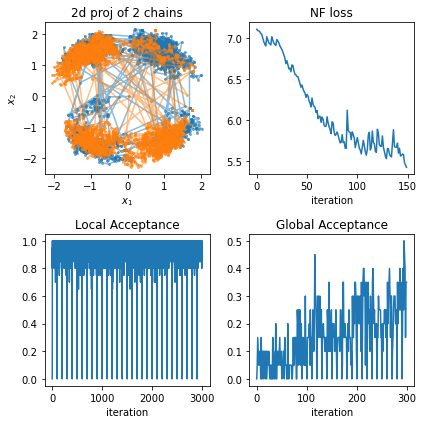

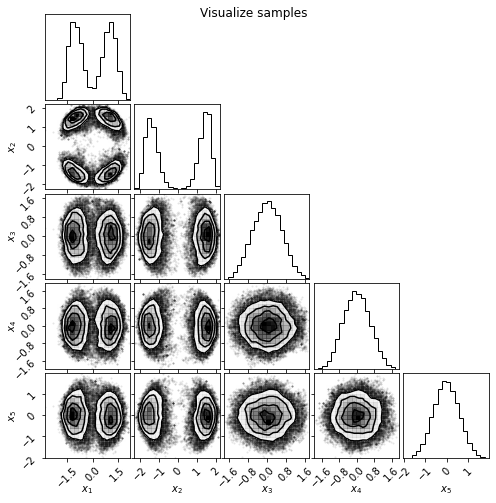

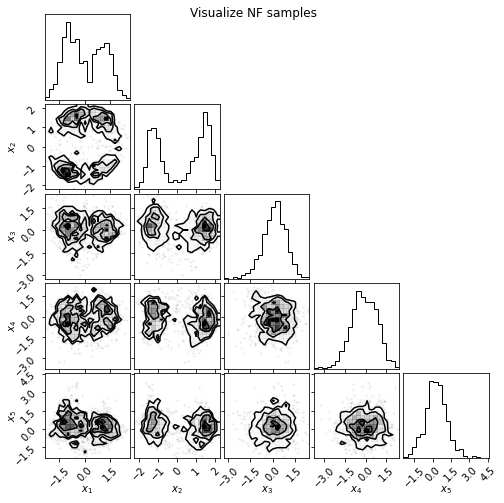

In [11]:
chains = np.array(out_train['chains'])
global_accs = np.array(out_train['global_accs'])
local_accs = np.array(out_train['local_accs'])
loss_vals = np.array(out_train['loss_vals'])
nf_samples = np.array(nf_sampler.sample_flow(1000)[1])


# Plot 2 chains in the plane of 2 coordinates for first visual check 
plt.figure(figsize=(6, 6))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[0, :, 0], chains[0, :, 1], 'o-', alpha=0.5, ms=2)
plt.plot(chains[1, :, 0], chains[1, :, 1], 'o-', alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals.reshape(-1))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(
    chains.reshape(-1, n_dim), labels=labels
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

# Plot Nf samples
figure = corner.corner(nf_samples, labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()


Second, let's analyze the production run. We will first visualize the samples and acceptance of the local and global sampler. 

In [12]:
out_prod = nf_sampler.get_sampler_state()   # default training=False
print('Logged in production:', out_prod.keys())

Logged in production: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs'])


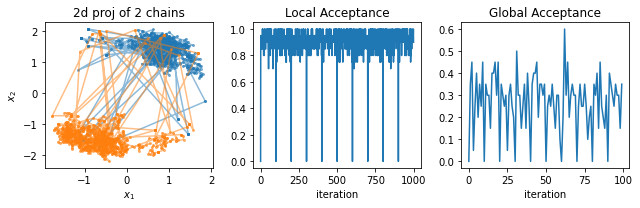

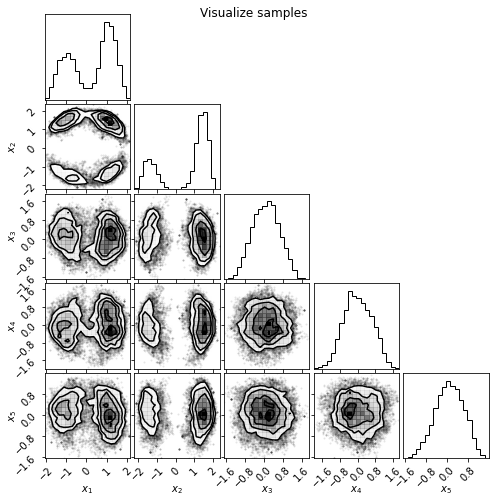

In [18]:
chains = np.array(out_prod['chains'])
global_accs = np.array(out_prod['global_accs'])
local_accs = np.array(out_prod['local_accs'])


plt.figure(figsize=(9, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[16, :, 0], chains[16, :, 1], 'o-', alpha=0.5, ms=2)
plt.plot(chains[6, :, 0], chains[6, :, 1], 'o-', alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(
    chains.reshape(-1, n_dim), labels=labels
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)


Next, we use the `arviz` package to compute $\hat R$ and the Effective Sample Size (ESS) as a function of the length of the chain.

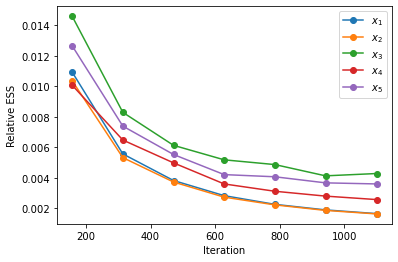

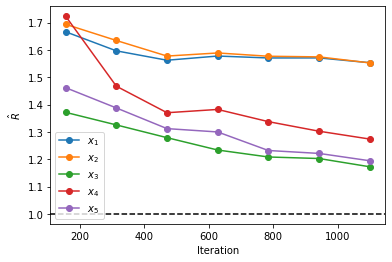

In [14]:
import arviz as az
from arviz.utils import get_coords, _var_names

## Load data as arviz InferenceData class
idata = az.convert_to_inference_data(chains)
coords = {}
data = get_coords(az.convert_to_dataset(idata, group="posterior"), coords)
var_names = None
filter_vars = None
var_names = _var_names(var_names, data, filter_vars)
n_draws = data.dims["draw"]
n_samples = n_draws * data.dims["chain"]
first_draw = data.draw.values[0] # int of where where things should start

## Compute where to split the data to diagnostic the convergence
n_split = 7
xdata = np.linspace(n_samples / n_split, n_samples, n_split)
draw_divisions = np.linspace(n_draws // n_split, n_draws, n_split, dtype=int)


relative = True # outputs ess/#samples
ess_s = np.stack([np.array(az.ess(data.sel(draw=slice(first_draw + draw_div)),
                    var_names=var_names,
                    relative=relative,
                    method="bulk",
                )['x'])
        for draw_div in draw_divisions
        ])

plt.figure()
plt.plot(draw_divisions, ess_s, '-o', label=labels)
plt.xlabel('Iteration')
plt.ylabel('Relative ESS')
plt.legend()


rhat_s = np.stack([np.array(az.rhat(data.sel(draw=slice(first_draw + draw_div)),
                    var_names=var_names,
                    method="rank",
                )['x'])
        for draw_div in draw_divisions
        ])

plt.figure()
plt.plot(draw_divisions, rhat_s, '-o',  label=labels)
plt.axhline(1, c='k', ls='--')
plt.xlabel('Iteration')
plt.ylabel(r'$\hat{R}$')
plt.legend()